In [1]:
import os
import re
import math
import cv2
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tqdm import tqdm
from glob import glob
from tools_copy.settings import *
from keras.models import Sequential
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tools_copy.train_val_test_spliter import split
import collections

In [31]:
split()

Splitting the ginen dataset into Train Test=0.2 Validation=0.2
Done


In [32]:
train = pd. read_csv(os.path.join(dataset_path, "train.csv"))
test = pd. read_csv(os.path.join(dataset_path, "test.csv"))
val = pd. read_csv(os.path.join(dataset_path, "val.csv"))

In [33]:
train.head()

,Video_url,action
0,E:\Project 103\Trimmed Data\kill/Kill_13.mp4,kill
1,E:\Project 103\Trimmed Data\smoke/smoke_25 .mp4,smoke
2,E:\Project 103\Trimmed Data\kill/Kill_34.mp4,kill
3,E:\Project 103\Trimmed Data\smoke/smoke_33 .mp4,smoke
4,E:\Project 103\Trimmed Data\smoke/smoke_106 .mp4,smoke


In [34]:
test.head()

,Video_url,action
0,E:\Project 103\Trimmed Data\smoke/smoke_57 .mp4,smoke
1,E:\Project 103\Trimmed Data\death/death_63.mp4,death
2,E:\Project 103\Trimmed Data\kill/Kill_2.mp4,kill
3,E:\Project 103\Trimmed Data\kill/Kill_65.mp4,kill
4,E:\Project 103\Trimmed Data\smoke/smoke_19 .mp4,smoke


In [35]:
val.head()

,Video_url,action
0,E:\Project 103\Trimmed Data\smoke/smoke_90 .mp4,smoke
1,E:\Project 103\Trimmed Data\kill/Kill_57.mp4,kill
2,E:\Project 103\Trimmed Data\smoke/smoke_93 .mp4,smoke
3,E:\Project 103\Trimmed Data\smoke/smoke_65 .mp4,smoke
4,E:\Project 103\Trimmed Data\kill/Kill_64.mp4,kill


In [36]:
print(train.shape)
print(test.shape)
print(val.shape)

(191, 2)
(61, 2)
(61, 2)


In [37]:
def convert_to_frame(data, folder_name):
    '''
    Generated filenames format dataset_path/folder_name/video_name_frame{number}_action.jpg
    '''
    directory = os.path.join(dataset_path, folder_name)
    if not os.path.exists(directory):
        os.makedirs(directory)
    for i in tqdm(range(data.shape[0])):
        video_file = data['Video_url'][i]
        action = data['action'][i]
        video_name_list = video_file.split('/')[-1].split('.')
        video_name_list = video_name_list[:-1]
        video_name = ""
        for n in video_name_list:
            video_name += n
        # capturing the video from the given path
        capture = cv2.VideoCapture(video_file) 
        #frame rate
        frame_rate = capture.get(5)
        count = 0
        while(capture.isOpened()):
            #current frame number
            frame_id = capture.get(1) 
            read_correctly, frame = capture.read()
            if not read_correctly:
                break
            if (frame_id % math.floor(frame_rate) == 0):
                # storing the frames in a new folder named train_1
                filename = directory + "/" + video_name + "_frame{}_".format(count) + action +".jpg"
                count += 1
                cv2.imwrite(filename, frame)
        capture.release()
    print("Successfully Converted")

In [38]:
convert_to_frame(train, train_frames_path_name)

100%|████████████████████████████████████████████████████████████████████████████████| 191/191 [02:32<00:00,  1.25it/s]

Successfully Converted


In [39]:
convert_to_frame(val, val_frames_path_name)

100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:43<00:00,  1.40it/s]

Successfully Converted


In [40]:
def create_paths_csv(directory, file_name):
    images = os.listdir(directory)
    images_path_list = []
    images_action_list = [] 
    for image in images:
        images_path_list.append(directory + image)
        images_action_list.append(image.split('.')[0].split('_')[-1])
    df = pd.DataFrame()
    df['image'] = images_path_list
    df['action'] = images_action_list
    print(os.path.join(dataset_path, file_name+'.csv'))
    df.to_csv(os.path.join(dataset_path, file_name+'.csv'), index=False)

In [41]:
create_paths_csv(train_frames_path, train_frames_path_name)

E:\Project 103\Trimmed Data\train_frames.csv


In [42]:
create_paths_csv(val_frames_path, val_frames_path_name)

E:\Project 103\Trimmed Data\val_frames.csv


In [43]:
train_image = pd.read_csv(os.path.join(dataset_path, 'train_frames.csv'))
train_image

,image,action
0,E:\Project 103\Trimmed Data\train_frames\death...,death
1,E:\Project 103\Trimmed Data\train_frames\death...,death
2,E:\Project 103\Trimmed Data\train_frames\death...,death
3,E:\Project 103\Trimmed Data\train_frames\death...,death
4,E:\Project 103\Trimmed Data\train_frames\death...,death
...,...,...
502,E:\Project 103\Trimmed Data\train_frames\smoke...,smoke
503,E:\Project 103\Trimmed Data\train_frames\smoke...,smoke
504,E:\Project 103\Trimmed Data\train_frames\smoke...,smoke
505,E:\Project 103\Trimmed Data\train_frames\smoke...,smoke


In [44]:
print(train_image.shape)

(507, 2)


In [45]:
val_image = pd.read_csv(os.path.join(dataset_path, 'val_frames.csv'))
val_image

,image,action
0,E:\Project 103\Trimmed Data\val_frames\death_1...,death
1,E:\Project 103\Trimmed Data\val_frames\death_1...,death
2,E:\Project 103\Trimmed Data\val_frames\death_1...,death
3,E:\Project 103\Trimmed Data\val_frames\death_1...,death
4,E:\Project 103\Trimmed Data\val_frames\death_1...,death
...,...,...
159,E:\Project 103\Trimmed Data\val_frames\smoke_9...,smoke
160,E:\Project 103\Trimmed Data\val_frames\smoke_9...,smoke
161,E:\Project 103\Trimmed Data\val_frames\smoke_9...,smoke
162,E:\Project 103\Trimmed Data\val_frames\smoke_9...,smoke


In [46]:
print(val_image.shape)

(164, 2)


In [47]:
action_values = list(train_image['action'].unique())
action_values

['death', 'kill', 'smoke']

In [48]:
def create_class_columns(df):
    for value in action_values:
        df[value] = np.where(df['action'].str.contains(value), 1, 0)
    df.drop('action', axis='columns', inplace=True)

In [49]:
create_class_columns(train_image)
train_image.head()

,image,death,kill,smoke
0,E:\Project 103\Trimmed Data\train_frames\death...,1,0,0
1,E:\Project 103\Trimmed Data\train_frames\death...,1,0,0
2,E:\Project 103\Trimmed Data\train_frames\death...,1,0,0
3,E:\Project 103\Trimmed Data\train_frames\death...,1,0,0
4,E:\Project 103\Trimmed Data\train_frames\death...,1,0,0


In [50]:
create_class_columns(val_image)
val_image.head()

,image,death,kill,smoke
0,E:\Project 103\Trimmed Data\val_frames\death_1...,1,0,0
1,E:\Project 103\Trimmed Data\val_frames\death_1...,1,0,0
2,E:\Project 103\Trimmed Data\val_frames\death_1...,1,0,0
3,E:\Project 103\Trimmed Data\val_frames\death_1...,1,0,0
4,E:\Project 103\Trimmed Data\val_frames\death_1...,1,0,0


In [51]:
def convert_to_array_and_split(image_data):
    image_value = []
    for i in tqdm(range(image_data.shape[0])):
        img = image.load_img(image_data['image'][i], target_size=(224,224,3))
        img = image.img_to_array(img)
        # normalizing the pixel value
        img = img / 255
        image_value.append(img)

    X = np.array(image_value)
    y = image_data
    y.drop('image', axis='columns', inplace=True)
    return X, y

In [52]:
X_train, y_train = convert_to_array_and_split(train_image)
print(X_train.shape)

100%|████████████████████████████████████████████████████████████████████████████████| 507/507 [00:13<00:00, 36.80it/s]


(507, 224, 224, 3)


In [53]:
X_val, y_val = convert_to_array_and_split(val_image)
print(X_val.shape)

100%|████████████████████████████████████████████████████████████████████████████████| 164/164 [00:03<00:00, 43.86it/s]


(164, 224, 224, 3)


In [54]:
#'warning'
X_train_set_copy = X_train
X_val_set_copy = X_val

In [55]:
X_train = X_train_set_copy
X_val = X_val_set_copy

In [56]:
X_train.shape

(507, 224, 224, 3)

In [57]:
y_train.head()

,death,kill,smoke
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


In [58]:
from tensorflow.keras.applications.vgg16 import VGG16
'''This model was trained on a dataset that has 1,000 classes. 
include_top = False will remove the last layer of this model so that we can tune it as per our need.
'''
base_model = VGG16(weights='imagenet', include_top=False)

In [59]:
X_train = base_model.predict(X_train)
X_train.shape

(507, 7, 7, 512)

In [60]:
X_val = base_model.predict(X_val)
X_val.shape

(164, 7, 7, 512)

In [61]:
#'warning'
X_train_copy = X_train
X_val_copy = X_val

In [91]:
X_train = X_train_copy
X_val = X_val_copy

In [92]:
X_train = X_train.reshape(X_train.shape[0], 7*7*512)
X_val = X_val.reshape(X_val.shape[0], 7*7*512)

In [93]:
max_pixel = X_train.max()
X_train = X_train / max_pixel
X_val = X_val / max_pixel
print(X_train.shape)
print(X_val.shape)

(507, 25088)
(164, 25088)


In [94]:
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(25088,)))
model.add(Dropout(0.5))
#model.add(Dense(512, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 512)               12845568  
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_12 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_13 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 3)                

In [95]:
from keras.callbacks import ModelCheckpoint
mcp_weight = ModelCheckpoint('weight_vgg16_final3_1.hdf5', save_best_only=True, monitor='val_loss', mode='min')

In [96]:
history=model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), callbacks=[mcp_weight], batch_size=128)

Epoch 1/20
4/4 [==============================] - 1s 203ms/step - loss: 1.0899 - accuracy: 0.3730 - val_loss: 0.9350 - val_accuracy: 0.4939
Epoch 2/20
4/4 [==============================] - 1s 145ms/step - loss: 0.9926 - accuracy: 0.5263 - val_loss: 0.7820 - val_accuracy: 0.6829
Epoch 3/20
4/4 [==============================] - 1s 144ms/step - loss: 0.8251 - accuracy: 0.6233 - val_loss: 0.6646 - val_accuracy: 0.7195
Epoch 4/20
4/4 [==============================] - 1s 143ms/step - loss: 0.6580 - accuracy: 0.7046 - val_loss: 0.5694 - val_accuracy: 0.7195
Epoch 5/20
4/4 [==============================] - 1s 144ms/step - loss: 0.5526 - accuracy: 0.7352 - val_loss: 0.5276 - val_accuracy: 0.7195
Epoch 6/20
4/4 [==============================] - 1s 143ms/step - loss: 0.5026 - accuracy: 0.7825 - val_loss: 0.5203 - val_accuracy: 0.7378
Epoch 7/20
4/4 [==============================] - 1s 143ms/step - loss: 0.4092 - accuracy: 0.8403 - val_loss: 0.4970 - val_accuracy: 0.7500
Epoch 8/20
4/4 [====

In [97]:
from scipy import stats as s
predict = []
actual = []
if not os.path.exists(test_frames_path):
    os.makedirs(test_frames_path)

for i in tqdm(range(test.shape[0])):
    video_file = test['Video_url'][i]
    action = test['action'][i]
    video_name_list = video_file.split('/')[-1].split('.')
    video_name_list = video_name_list[:-1]
    video_name = ""
    for n in video_name_list:
        video_name += n
    # capturing the video from the given path
    capture = cv2.VideoCapture(video_file) 
    #frame rate
    frame_rate = capture.get(5)
    count = 0
    files = glob(test_frames_path + '/*')
    #removing all files from folder
    for f in files:
        os.remove(f)
    while(capture.isOpened()):
        #current frame number
        frame_id = capture.get(1) 
        read_correctly, frame = capture.read()
        if not read_correctly:
            break
        if (frame_id % math.floor(frame_rate) == 0):
            # storing the frames in a new folder named train_1
            filename = test_frames_path + "/" + video_name + "_frame{}_".format(count) + action +".jpg"
            count += 1
            cv2.imwrite(filename, frame)
    capture.release()
    
    # reading all the frames from temp folder
    images = glob(test_frames_path + '/*.jpg')
    prediction_images = []
    for i in range(len(images)):
        img = image.load_img(images[i], target_size=(224,224,3))
        img = image.img_to_array(img)
        img = img / 255
        prediction_images.append(img)
        
    # converting all the frames for a test video into numpy array
    prediction_images = np.array(prediction_images)
    #prediction_images = prediction_images / max_pixel
    # extracting features using pre-trained model
    prediction_images = base_model.predict(prediction_images)
    # converting features in one dimensional array
    prediction_images = prediction_images.reshape(prediction_images.shape[0], 7*7*512)
    # predicting tags for each array
    prediction = np.argmax(model.predict(prediction_images), axis=-1)
    # appending the mode of predictions in predict list to assign the tag to the video
    predict.append(y_train.columns.values[s.mode(prediction)[0][0]])
    # appending the actual tag of the video
    actual.append(action)

100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [01:29<00:00,  1.47s/it]


In [98]:
from sklearn.metrics import accuracy_score
accuracy_score(predict, actual)*100

85.24590163934425

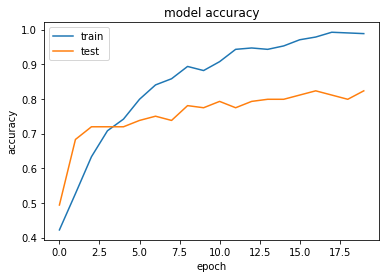

In [99]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

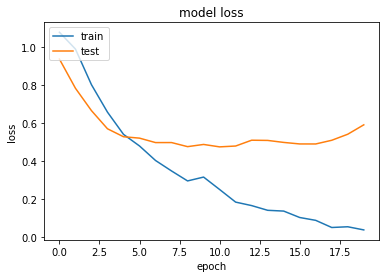

In [100]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [104]:
from tensorflow.keras.applications.xception import Xception
'''This model was trained on a dataset that has 1,000 classes. 
include_top = False will remove the last layer of this model so that we can tune it as per our need.
'''
base_model = Xception(weights='imagenet', include_top=False)

In [105]:
X_train = base_model.predict(X_train)
X_train.shape

(735, 7, 7, 2048)

In [106]:
X_val = base_model.predict(X_val)
X_val.shape

(235, 7, 7, 2048)

In [107]:
#'warning'
X_train_copy = X_train
X_val_copy = X_val

In [72]:
X_train = X_train_copy
X_val = X_val_copy

In [108]:
X_train = X_train.reshape(X_train.shape[0], 7*7*2048)
X_val = X_val.reshape(X_val.shape[0], 7*7*2048)

max_pixel = X_train.max()
X_train = X_train / max_pixel
X_val = X_val / max_pixel
print(X_train.shape)
print(X_val.shape)

model = Sequential()
model.add(Dense(1024, activation='relu', input_shape=(100352,)))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
model.summary()

from keras.callbacks import ModelCheckpoint
mcp_weight = ModelCheckpoint('weight_xception_final1_1.hdf5', save_best_only=True, monitor='val_loss', mode='min')

history=model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val), callbacks=[mcp_weight], batch_size=147)

(735, 100352)
(235, 100352)
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 1024)              102761472 
_________________________________________________________________
dropout_16 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_17 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_18 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_23 (Dense)          

In [110]:
from scipy import stats as s
predict = []
actual = []
if not os.path.exists(test_frames_path):
    os.makedirs(test_frames_path)

for i in tqdm(range(test.shape[0])):
    video_file = test['Video_url'][i]
    action = test['action'][i]
    video_name_list = video_file.split('/')[-1].split('.')
    video_name_list = video_name_list[:-1]
    video_name = ""
    for n in video_name_list:
        video_name += n
    # capturing the video from the given path
    capture = cv2.VideoCapture(video_file) 
    #frame rate
    frame_rate = capture.get(5)
    count = 0
    files = glob(test_frames_path + '/*')
    #removing all files from folder
    for f in files:
        os.remove(f)
    while(capture.isOpened()):
        #current frame number
        frame_id = capture.get(1) 
        read_correctly, frame = capture.read()
        if not read_correctly:
            break
        if (frame_id % math.floor(frame_rate) == 0):
            # storing the frames in a new folder named train_1
            filename = test_frames_path + "/" + video_name + "_frame{}_".format(count) + action +".jpg"
            count += 1
            cv2.imwrite(filename, frame)
    capture.release()
    
    # reading all the frames from temp folder
    images = glob(test_frames_path + '/*.jpg')
    prediction_images = []
    for i in range(len(images)):
        img = image.load_img(images[i], target_size=(224,224,3))
        img = image.img_to_array(img)
        img = img / 255
        prediction_images.append(img)
        
    # converting all the frames for a test video into numpy array
    prediction_images = np.array(prediction_images)
    #prediction_images = prediction_images / max_pixel
    # extracting features using pre-trained model
    prediction_images = base_model.predict(prediction_images)
    # converting features in one dimensional array
    prediction_images = prediction_images.reshape(prediction_images.shape[0], 7*7*2048)
    # predicting tags for each array
    prediction = np.argmax(model.predict(prediction_images), axis=-1)
    # appending the mode of predictions in predict list to assign the tag to the video
    predict.append(y_train.columns.values[s.mode(prediction)[0][0]])
    # appending the actual tag of the video
    actual.append(action)

100%|██████████████████████████████████████████████████████████████████████████████████| 81/81 [01:30<00:00,  1.12s/it]


In [111]:
from sklearn.metrics import accuracy_score
accuracy_score(predict, actual)*100

72.8395061728395

In [152]:
def frame_no(video_name):
    cap= cv2.VideoCapture(video_name)
    i=0
    while(cap.isOpened()):
        ret, frame = cap.read()
        if ret == False:
            break
    
        frameId = cap.get(1)
    
    #cap.release()
    #cv2.destroyAllWindows()
    return frameId

filepath = 'E:\Project 103\prediction_count'
j=0
video_name = 'kill_69.mp4'
frame_needed = 30
cap= cv2.VideoCapture(video_name)
#frameRate = cap.get(5)
tot_frame = frame_no(video_name)
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == False:
        break
    frameId = cap.get(1)

    a = np.linspace(0, tot_frame, frame_needed)

    for i in range(len(a)):
        if (frameId == math.floor(a[i])):
            final_filepath = os.path.join(filepath, 'predict_frame'+str(j)+'.jpg')
            cv2.imwrite(final_filepath,frame)
            j+=1

cap.release()
cv2.destroyAllWindows()

In [116]:
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
from moviepy.editor import VideoFileClip

end_time = 150
start_time = 90
clip = VideoFileClip("z3.mp4")
dur_int = int(clip.duration)
ffmpeg_extract_subclip("z3.mp4", start_time, end_time, targetname="z3short2.mp4")

Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful


In [117]:
def frame_no(video_name):
    cap= cv2.VideoCapture(video_name)
    i=0
    while(cap.isOpened()):
        ret, frame = cap.read()
        if ret == False:
            break
    
        frameId = cap.get(1)
    
    #cap.release()
    #cv2.destroyAllWindows()
    return frameId

filepath = 'E:\Project 103\prediction_count'
images = glob(filepath + '/*.jpg')

for f in images:
    os.remove(f)

filepath = 'E:\Project 103\prediction_count'
j=0
video_name = 'z3short2.mp4'

cap= cv2.VideoCapture(video_name)
fps = cap.get(cv2.CAP_PROP_FPS)     
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
duration = int(frame_count/fps)

frame_needed = duration*2

tot_frame = frame_no(video_name)
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == False:
        break
    frameId = cap.get(1)

    a = np.linspace(0, tot_frame, frame_needed)

    for i in range(len(a)):
        if (frameId == math.floor(a[i])):
            final_filepath = os.path.join(filepath, 'predict_frame'+str(j)+'.jpg')
            cv2.imwrite(final_filepath,frame)
            j+=1

cap.release()
cv2.destroyAllWindows()

images = glob(filepath + '/*.jpg')

prediction_images = []
predict = []
predict2 = []
for i in range(len(images)):
    img = image.load_img(images[i], target_size=(224,224,3))
    img = image.img_to_array(img)
    img = img / 255
    prediction_images.append(img)

prediction_images = np.array(prediction_images)
prediction_images = base_model.predict(prediction_images)
prediction_images = prediction_images.reshape(prediction_images.shape[0], 7*7*512)
predict = model.predict(prediction_images)
a = np.argmax(predict)
#print(predict)
def maxfunction(x):
        return np.argmax(x)

prediction = np.apply_along_axis( maxfunction, axis=1, arr=predict )

print(prediction)

filepath = 'E:\Project 103\prediction_count'
images = glob(filepath + '/*.jpg')

for f in images:
    os.remove(f)

[2 2 2 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 2 0 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0
 0 1 1 2 0 0 0 1 1 1 1 1 1 1 2 1 1 1 1 1 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 2
 0 0 0 0 0 0 0 0 0 0]


In [119]:
z=0
kill_count=0
death_count=0
threshold=7
range_=10

for i in prediction:
    if z>=len(prediction):
        break
    
    elif prediction[z]==1:
            prove = prediction[z:(z+range_)]
            #print(z,':for 1')
            counter=collections.Counter(prove)
            dictionary = dict(counter)
            try:
                if dictionary[1]>=threshold:
                    #print('kill!')
                    kill_count+=1
                    
                    z=z+threshold-1
                   
            except:
                #print('oops')
                pass
            
    elif prediction[z]==0:
            prove = prediction[z:(z+range_)]
            counter=collections.Counter(prove)
            dictionary = dict(counter)
            #print(z, ':for 2')
            try:
                if dictionary[0]>=threshold:
                    #print('death!')
                    
                    death_count+=1
                    z=z+threshold-1
            except:
                #print('oops')
                pass
            
    else:
        pass
    #print(prove)
    
    z+=1
    #print(z)
print('Kill: ',kill_count)
print('Death: ',death_count)



Kill:  1
Death:  6


In [59]:
filepath = 'E:\Project 103\prediction_count'
images = glob(filepath + '/*.jpg')

for f in images:
    os.remove(f)

In [342]:
def frame_no(video_name):
    cap= cv2.VideoCapture(video_name)
    i=0
    while(cap.isOpened()):
        ret, frame = cap.read()
        if ret == False:
            break
    
        frameId = cap.get(1)
    
    #cap.release()
    #cv2.destroyAllWindows()
    return frameId

filepath = 'E:\Project 103\prediction_count'
j=0
video_name = 'z1short.mp4'

cap= cv2.VideoCapture(video_name)
fps = cap.get(cv2.CAP_PROP_FPS)     
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
duration = int(frame_count/fps)

frame_needed = duration*2

tot_frame = frame_no(video_name)
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == False:
        break
    frameId = cap.get(1)

    a = np.linspace(0, tot_frame, frame_needed)

    for i in range(len(a)):
        if (frameId == math.floor(a[i])):
            final_filepath = os.path.join(filepath, 'predict_frame'+str(j)+'.jpg')
            cv2.imwrite(final_filepath,frame)
            j+=1

cap.release()
cv2.destroyAllWindows()

images = glob(filepath + '/*.jpg')

prediction_images = []
predict = []
predict2 = []
for i in range(len(images)):
    img = image.load_img(images[i], target_size=(224,224,3))
    img = image.img_to_array(img)
    img = img / 255
    prediction_images.append(img)

prediction_images = np.array(prediction_images)
prediction_images = base_model.predict(prediction_images)
prediction_images = prediction_images.reshape(prediction_images.shape[0], 7*7*512)
predict = model.predict(prediction_images)
a = np.argmax(predict)
#print(predict)
def maxfunction(x):
        return np.argmax(x)

prediction2 = np.apply_along_axis( maxfunction, axis=1, arr=predict )

print(prediction2)

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 0 2 2 2 2 2 2 2 0 0
 0 0 0 2 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 0 2 2 0 2 2 2 2 2]


In [343]:
z=0
kill_count=0
death_count=0
threshold=7
range_=10

for i in prediction2:
    if z>=len(prediction2):
        break
    
    elif prediction2[z]==1:
            prove = prediction2[z:(z+range_)]
            #print(z,':for 1')
            counter=collections.Counter(prove)
            dictionary = dict(counter)
            try:
                if dictionary[1]>=threshold:
                    #print('kill!')
                    kill_count+=1
                    
                    z=z+threshold-1
                   
            except:
                #print('oops')
                pass
    elif prediction2[z]==0:
            prove = prediction2[z:(z+range_)]
            counter=collections.Counter(prove)
            dictionary = dict(counter)
            #print(z, ':for 2')
            try:
                if dictionary[0]>=threshold:
                    #print('death!')
                    
                    death_count+=1
                    z=z+threshold-1
            except:
                #print('oops')
                pass
    else:
        pass
    #print(prove)
    
    z+=1
    #print(z)
print('Kill: ',kill_count)
print('Death: ',death_count)

Kill:  0
Death:  1


In [324]:
a=[1,2,3,4,5]
a[3:5]

[4, 5]

61

Kill:  0
Death:  1


In [ ]:
cap = cv2.VideoCapture("z1short.mp4")
fps = cap.get(cv2.CAP_PROP_FPS)     
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
duration = int(frame_count/fps)
duration

In [248]:
a = prediction[101:108]
len(a)

7

In [136]:
y_train.columns.values

array(['death', 'kill', 'NoAction'], dtype=object)

In [117]:
prediction.shape

(5,)

In [113]:
for i in images:
    print(i)

E:\Project 103\prediction_count\predict_frame0.jpg
E:\Project 103\prediction_count\predict_frame1.jpg
E:\Project 103\prediction_count\predict_frame2.jpg
E:\Project 103\prediction_count\predict_frame3.jpg
E:\Project 103\prediction_count\predict_frame4.jpg


In [95]:
from sklearn.metrics import accuracy_score
accuracy_score(predict, actual)*100

78.33333333333333

In [72]:
predict

['kill',
 'NoAction',
 'NoAction',
 'kill',
 'NoAction',
 'kill',
 'NoAction',
 'death',
 'death',
 'death',
 'kill',
 'NoAction',
 'death',
 'kill',
 'death',
 'death',
 'kill',
 'death',
 'death',
 'death',
 'kill',
 'kill',
 'NoAction',
 'death',
 'kill',
 'NoAction',
 'death',
 'NoAction',
 'NoAction',
 'NoAction',
 'kill',
 'NoAction',
 'death',
 'kill',
 'death',
 'kill',
 'kill',
 'death',
 'NoAction',
 'NoAction',
 'kill',
 'NoAction',
 'NoAction',
 'kill',
 'death',
 'death',
 'NoAction',
 'death',
 'death',
 'death',
 'kill',
 'kill',
 'NoAction',
 'death',
 'NoAction',
 'kill',
 'kill',
 'NoAction',
 'death',
 'NoAction']

In [81]:
import collections
counter=collections.Counter(predict)
print(counter)

Counter({'death': 21, 'NoAction': 20, 'kill': 19})


In [82]:
counter=collections.Counter(actual)
print(counter)

Counter({'death': 20, 'NoAction': 20, 'kill': 20})


In [5]:
model.load_weights("weight_vgg16_final1.hdf5")
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              25691136  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               3

In [36]:
from scipy import stats as s
predict = []
actual = []
if not os.path.exists(test_frames_path):
    os.makedirs(test_frames_path)

for i in tqdm(range(test.shape[0])):
    video_file = test['Video_url'][i]
    action = test['action'][i]
    video_name_list = video_file.split('/')[-1].split('.')
    video_name_list = video_name_list[:-1]
    video_name = ""
    for n in video_name_list:
        video_name += n
    # capturing the video from the given path
    capture = cv2.VideoCapture(video_file) 
    #frame rate
    frame_rate = capture.get(5)
    count = 0
    files = glob(test_frames_path + '/*')
    #removing all files from folder
    for f in files:
        os.remove(f)
    while(capture.isOpened()):
        #current frame number
        frame_id = capture.get(1) 
        read_correctly, frame = capture.read()
        if not read_correctly:
            break
        if (frame_id % math.floor(frame_rate) == 0):
            # storing the frames in a new folder named train_1
            filename = test_frames_path + "/" + video_name + "_frame{}_".format(count) + action +".jpg"
            count += 1
            cv2.imwrite(filename, frame)
    capture.release()
    
    # reading all the frames from temp folder
    images = glob(test_frames_path + '/*.jpg')
    prediction_images = []
    for i in range(len(images)):
        img = image.load_img(images[i], target_size=(224,224,3))
        img = image.img_to_array(img)
        img = img / 255
        prediction_images.append(img)
        
    # converting all the frames for a test video into numpy array
    prediction_images = np.array(prediction_images)
    #prediction_images = prediction_images / max_pixel
    # extracting features using pre-trained model
    prediction_images = base_model.predict(prediction_images)
    # converting features in one dimensional array
    prediction_images = prediction_images.reshape(prediction_images.shape[0], 7*7*512)
    # predicting tags for each array
    prediction = np.argmax(model.predict(prediction_images), axis=-1)
    # appending the mode of predictions in predict list to assign the tag to the video
    predict.append(y_train.columns.values[s.mode(prediction)[0][0]])
    # appending the actual tag of the video
    actual.append(action)

100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [01:23<00:00,  1.38s/it]


In [37]:
from sklearn.metrics import accuracy_score
accuracy_score(predict, actual)*100

90.0

In [39]:
X_best_train = X_train
y_best_train = y_train

X_best_val = X_val
y_best_val = y_val

test_best = test

In [40]:
test.shape

(60, 2)

In [41]:
test_best.shape

(60, 2)